## Experiment Setup

In [1]:
# Import Statements / Setup
from Dataset import Dataset
import matplotlib.pyplot as plt
import numpy as np
from preprocess_data import filter_genres
import sklearn
import time

from models.Model import Model
from models.CNNModel import CNNModel
from models.LogisticRegression import LogisticRegression


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def current_time_millis():
    return int(round(time.time() * 1000))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load / Preprocess Data

In [2]:
np.random.seed(123456789) # Make ordering of data consistent b/w runs

# List of all genres
ALL_GENRES_LIST = [
    'Action', 'Adventure', 'Animation', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'History', 'Horror', 'Music', 'Mystery', 'Romance',
    'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'
]

# List of genres which we will attempt to classify.
#USED_GENRES_LIST = [
#    'Action', 'Comedy'
#]
USED_GENRES_LIST = ALL_GENRES_LIST

# Load and Shuffle Data.
start_time = current_time_millis()
posters = np.load('movie_data/posters_float.npy')
genres = np.load('movie_data/genres.npy')
posters, genres = sklearn.utils.shuffle(posters, genres)
end_time = current_time_millis()
print('Loading Data took {0} seconds\n'.format((end_time-start_time)/1000.0))

# Remove genres which we are not attempting to classify
genres = filter_genres(ALL_GENRES_LIST, USED_GENRES_LIST, genres)
percentages = np.mean(genres, axis=0)
print('Fraction of examples which belong to genre:')
for i, genre in enumerate(USED_GENRES_LIST):
    print('{0} : {1:.2f}'.format(genre, percentages[i]))

Loading Data took 432.82 seconds

Fraction of examples which belong to genre:
Action : 0.18
Adventure : 0.10
Animation : 0.07
Comedy : 0.33
Crime : 0.11
Documentary : 0.05
Drama : 0.44
Family : 0.08
Fantasy : 0.07
History : 0.03
Horror : 0.14
Music : 0.03
Mystery : 0.06
Romance : 0.15
Science Fiction : 0.08
TV Movie : 0.02
Thriller : 0.20
War : 0.03
Western : 0.02


## Initializing Train / Validation / Test Datasets

In [ ]:
# TRAIN/VALID/TEST SPLIT = 75/15/10
TRAIN_SPLIT = int(np.ceil(len(posters) * 0.75))
VALID_SPLIT = TRAIN_SPLIT + int(np.ceil(len(posters) * 0.15))

train_dataset = Dataset(posters[:TRAIN_SPLIT], genres[:TRAIN_SPLIT])
print('here0')
train_mean, train_std = train_dataset.get_original_mean_and_std()
print('here1')

valid_dataset = Dataset(
    posters[TRAIN_SPLIT:VALID_SPLIT],
    genres[TRAIN_SPLIT:VALID_SPLIT],
    mean = train_mean,
    std = train_std
)
print('here2')

test_dataset = Dataset(
    posters[VALID_SPLIT:],
    genres[VALID_SPLIT:],
    mean = train_mean,
    std = train_std
)
print('here3')

print('Total Number of Examples: {0}'.format(len(posters)))
print('Number of Train/Valid/Test Examples: {0}/{1}/{2}'.format(
    train_dataset.size(),
    valid_dataset.size(),
    test_dataset.size()
))
print('Image Size: {0}'.format(posters.shape[1:]))
print('Number of Genres: {0}'.format(genres.shape[1]))

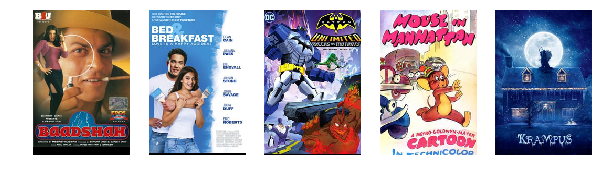

In [9]:
rows, columns = 1, 5
fig = plt.figure()
for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_dataset.X[i-1])
    plt.axis('off')

## Baseline Model (Logistic Regression)

In [4]:
def flatten_dataset(dataset):
    return Dataset(
        np.reshape(dataset.X, (dataset.size(), -1)),
        dataset.y
    )

flat_train_dataset = flatten_dataset(train_dataset)
flat_valid_dataset = flatten_dataset(valid_dataset)

model = LogisticRegression(
    USED_GENRES_LIST,
    flat_train_dataset.X.shape[1]
)
model.train(
    flat_train_dataset,
    flat_valid_dataset,
    num_epochs = 10,
    verbose=True
)

Initializing model...Done.


Epoch #1 out of 10:   43% | loss:   10.9 | accuracy:  0.557 | ETA:   0:00:13   

KeyboardInterrupt: 

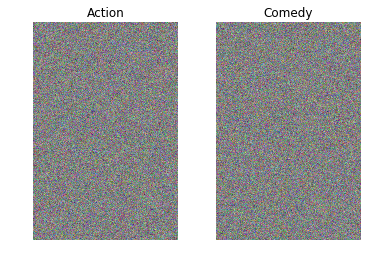

In [6]:
W = model.get_weights()
W = np.reshape(W, (278, 185, 3, len(USED_GENRES_LIST)))

W_min, W_max = np.min(W), np.max(W)
for i in range(len(USED_GENRES_LIST)):
    plt.subplot(1, len(USED_GENRES_LIST), i + 1)
    # Rescale the weights to be between 0 and 255
    W_img = 255.0 * (W[:, :, :, i].squeeze() - W_min) / (W_max - W_min)
    plt.imshow(W_img.astype('uint8'))
    plt.axis('off')
    plt.title(USED_GENRES_LIST[i])

## CNN Model

In [15]:
model = CNNModel(
    USED_GENRES_LIST,
    posters.shape[1:]
)

model.train(
    train_dataset,
    valid_dataset,
    num_epochs = 10,
    learning_rate=1e-4,
    verbose=True
)

Initializing model...Done.
Training Model...


Epoch #1 out of 10:   47% | loss:     23 | accuracy:   0.78 | ETA:   0:01:55   

KeyboardInterrupt: 